In [1]:
# As usual, a bit of setup

import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import pickle

from gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from layers import *
from rnn import *
from solver import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [40]:
raw = pickle.load(open("stories.pck", "rb"))
print len(raw), "examples"
print max([len(x) for x in raw]), "supporting facts and questions at most"
print max([len(y.split(' ')) for y in x for x in raw]), "words per sentence at most"

_null, _start, _query, _end = "<NULL>", "<Start>", "<Query>", "<End>"

words = [_null, _start, _query, _end] + [q for ex in raw for sent in ex for w in sent.split(' ') for q in w.split(',')]
words = sorted(set(words))
word_to_idx = {w:i for i,w in enumerate(words)}

T = 64 # longest story, 64 words unfolding
T2= 5

data = []
for ex in raw[:-1000]:
    sLen = 0
    while ex[sLen].find(',')==-1:
        sLen+=1
    supports = word_to_idx[_null] * np.ones(T, dtype=int)
    queries = word_to_idx[_null] * np.ones((len(ex)-sLen, T2), dtype=int)
    
    pos=0
    for idx, sent in enumerate(ex):
        if idx<sLen:
            sent = [word_to_idx[_start]] + [word_to_idx[x] for x in sent.split(' ')] 
            supports[pos:pos+len(sent)+1] = sent + [word_to_idx[_end]]
            pos += len(sent)
        else:
            sent = sent.split(',')[0]
            sent = [word_to_idx[_query]] + [word_to_idx[x] for x in sent.split(' ')]
            sent = sent + [word_to_idx[_null]]*(T2-len(sent)-1) + [word_to_idx[_end]]#null pad the sentence
            queries[idx-sLen, :] = sent
    
    answers = np.asarray([word_to_idx[x.split(',')[1]] for x in ex[sLen:]]).reshape(len(ex)-sLen, 1)
    for i in xrange(queries.shape[0]):
        data.append(np.hstack((supports, queries[i,:], answers[i,:])))

data_train = np.asarray(data)
data = []
for ex in raw[-1000:]:
    sLen = 0
    while ex[sLen].find(',')==-1:
        sLen+=1
    supports = word_to_idx[_null] * np.ones(T, dtype=int)
    queries = word_to_idx[_null] * np.ones((len(ex)-sLen, T2), dtype=int)
    
    pos=0
    for idx, sent in enumerate(ex):
        if idx<sLen:
            sent = [word_to_idx[_start]] + [word_to_idx[x] for x in sent.split(' ')] 
            supports[pos:pos+len(sent)+1] = sent + [word_to_idx[_end]]
            pos += len(sent)
        else:
            sent = sent.split(',')[0]
            sent = [word_to_idx[_query]] + [word_to_idx[x] for x in sent.split(' ')]
            sent = sent + [word_to_idx[_null]]*(T2-len(sent)-1) + [word_to_idx[_end]]#null pad the sentence
            queries[idx-sLen, :] = sent
    
    answers = np.asarray([word_to_idx[x.split(',')[1]] for x in ex[sLen:]]).reshape(len(ex)-sLen, 1)
    for i in xrange(queries.shape[0]):
        data.append(np.hstack((supports, queries[i,:], answers[i,:])))

data_test = np.asarray(data)

10000 examples
29 supporting facts and questions at most
5 words per sentence at most


(Iteration 1 / 400) loss: 5.128037
(Iteration 11 / 400) loss: 2.836410
(Iteration 21 / 400) loss: 2.644524
(Iteration 31 / 400) loss: 2.422662
(Iteration 41 / 400) loss: 2.357525
(Iteration 51 / 400) loss: 2.232610
(Iteration 61 / 400) loss: 1.816278
(Iteration 71 / 400) loss: 1.775753
(Iteration 81 / 400) loss: 1.434769
(Iteration 91 / 400) loss: 1.246429
(Iteration 101 / 400) loss: 1.114377
(Iteration 111 / 400) loss: 1.094489
(Iteration 121 / 400) loss: 0.652451
(Iteration 131 / 400) loss: 0.439813
(Iteration 141 / 400) loss: 0.277109
(Iteration 151 / 400) loss: 0.250740
(Iteration 161 / 400) loss: 0.161047
(Iteration 171 / 400) loss: 0.179991
(Iteration 181 / 400) loss: 0.077546
(Iteration 191 / 400) loss: 0.076629
(Iteration 201 / 400) loss: 0.065813
(Iteration 211 / 400) loss: 0.064291
(Iteration 221 / 400) loss: 0.039406
(Iteration 231 / 400) loss: 0.032802
(Iteration 241 / 400) loss: 0.041589
(Iteration 251 / 400) loss: 0.038557
(Iteration 261 / 400) loss: 0.037531
(Iteration 2

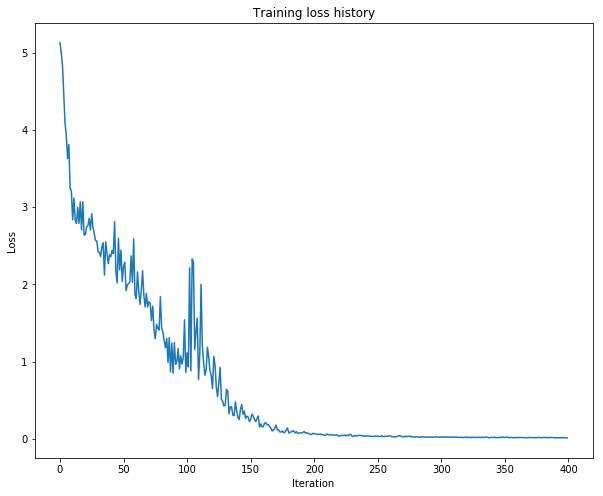

In [44]:
model = SeqNN(word_to_idx, cell_type='rnn', hidden_dim=256, wordvec_dim=512)
solver = SeqNNSolver(model, data_train[:50],
           update_rule='adam',
           num_epochs=200,
           batch_size=25,
           optim_config={
             'learning_rate': 1e-3,
           },
           lr_decay=.995,
           verbose=True, print_every=10,
         )
solver.train()

# Plot the training losses
plt.plot(solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

In [46]:
minibatch = data_train[:50]
print "Train:",
answ=model.loss(minibatch, sample=True)
print (answ==minibatch[:,-1]).mean()

print "\n".join(" ".join([words[x] for x in data_train[0,:-T2-1]]).split(_start))
i=0
while np.all(data_train[0,:-T2-1]==data_train[i,:-T2-1]):
  print " ".join([words[x] for x in data_train[i,-T2-1:]])
  i=i+1

print
print "Other answers:"
print "\n".join([words[x]+" "+words[y] for x,y in zip(model.loss(minibatch, sample=True), minibatch[:,-1])])

Train: 1.0

 cengiz eva gitti . 
 veli semsiyeyi dolapdan aldi . <End> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL>
<Query> cengiz nerede ? <End> ev
<Query> semsiye nerede ? <End> dolap
<Query> veli nerede ? <End> dolap

Other answers:
ev ev
dolap dolap
dolap dolap
amfi amfi
amfi amfi
sandalye sandalye
mutfak mutfak
sandalye sandalye
labaratuvar labaratuvar
bahce bahce
bahce bahce
mutfak mutfak
kamyon kamyon
labaratuvar labaratuvar
mutfak mutfak
bahce bahce
otobus otobus
amfi amfi
amfi amfi
bahce bahce
bahce bahce
dolap dolap
dolap dolap
servis servis
bolum bolum
servis servis
otobus otobus
hastane hastane
bolum bolum
hastane hastane
tuvalet tuvalet
masa masa
tuvalet tuval

In [47]:
model = SeqNN(word_to_idx, cell_type='rnn', hidden_dim=512, wordvec_dim=512)
solver = SeqNNSolver(model, data_train,
           update_rule='adam',
           num_epochs=10,
           batch_size=25,
           optim_config={
             'learning_rate': 1e-3,
           },
           lr_decay=.995,
           verbose=True, print_every=10,
         )
solver.train()

# Plot the training losses
plt.plot(solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

(Iteration 1 / 26880) loss: 5.070920
(Iteration 11 / 26880) loss: 4.941373
(Iteration 21 / 26880) loss: 5.038448
(Iteration 31 / 26880) loss: 4.160856
(Iteration 41 / 26880) loss: 3.991765
(Iteration 51 / 26880) loss: 3.645830
(Iteration 61 / 26880) loss: 3.601724
(Iteration 71 / 26880) loss: 3.611482
(Iteration 81 / 26880) loss: 3.332152
(Iteration 91 / 26880) loss: 3.504351
(Iteration 101 / 26880) loss: 3.337870
(Iteration 111 / 26880) loss: 3.595950
(Iteration 121 / 26880) loss: 3.658091
(Iteration 131 / 26880) loss: 3.600867
(Iteration 141 / 26880) loss: 3.407123
(Iteration 151 / 26880) loss: 3.512154
(Iteration 161 / 26880) loss: 3.639323
(Iteration 171 / 26880) loss: 3.321106
(Iteration 181 / 26880) loss: 3.486593
(Iteration 191 / 26880) loss: 3.501521
(Iteration 201 / 26880) loss: 3.427790
(Iteration 211 / 26880) loss: 3.744384
(Iteration 221 / 26880) loss: 3.777005
(Iteration 231 / 26880) loss: 3.288039
(Iteration 241 / 26880) loss: 3.488252
(Iteration 251 / 26880) loss: 3.4991

KeyboardInterrupt: 

In [ ]:
print "Train:",
answ=model.loss(data_train[:1000,:], sample=True)
print (answ==data_train[:1000,-1]).mean()
minibatch = data_train[:10]
print "\n".join([words[x]+" "+words[y] for x,y in zip(model.loss(minibatch, sample=True), minibatch[:,-1])])

print
print "Test:",
answ=model.loss(data_test, sample=True)
print (answ==data_test[:,-1]).mean()
minibatch = data_test[:10]
print "\n".join([words[x]+" "+words[y] for x,y in zip(model.loss(minibatch, sample=True), minibatch[:,-1])])

In [ ]:
model = SeqNN(word_to_idx, cell_type='rnn', hidden_dim=512, wordvec_dim=256)
solver = SeqNNSolver(model, data_train[:50],
           update_rule='adam',
           num_epochs=100,
           batch_size=25,
           optim_config={
             'learning_rate': 5e-3,
           },
           lr_decay=.995,
           verbose=True, print_every=10,
         )
solver.train()

# Plot the training losses
plt.plot(solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

In [ ]:
idx = np.random.choice(data_train.shape[0], 1000)
minibatch = data_train[:50,:]
print "Train:",
answ=model.loss(minibatch, sample=True)
print (answ==minibatch[:,-1]).mean()
print "\n".join([words[x]+" "+words[y] for x,y in zip(model.loss(minibatch[:50,:], sample=True), minibatch[:50,-1])])

print
minibatch = data_test
print "Test:",
answ=model.loss(minibatch, sample=True)
print (answ==minibatch[:,-1]).mean()
print "\n".join([words[x]+" "+words[y] for x,y in zip(model.loss(minibatch[:50,:], sample=True), minibatch[:50,-1])])